# Shor's Factoring Algorithm


<blockquote style="background:rgba(59,130,246,.08);border-left:6px solid #3b82f6;padding:1rem 1.25rem;margin:.5rem 0;">
<strong>Integer factorization</strong> [<a href="#ref-integerfactor">1</a>],   is a famous problem in number theory: given a composite number $N$, find its prime factors. The importance of the problem stems from there being no known efficient classical algorithm (in the number of bits needed to represent $N$ in polynomial time), and much of modern-day cryptography relies on this fact. In 1994, Peter Shor came up with an efficient <strong>  quantum </strong> algorithm for the problem [<a href="#ref-shor94">2</a>]; providing, arguably, the most important evidence for an exponential advantage of quantum computing over classical computing.
 <br> 
    <ul> 
        <li><strong>Input:</strong> A composite integer $N$ .
        </li> 
        <li><strong>Promise:</strong> $N$ is not a prime power and has at least one nontrivial factor.
        </li> <li><strong>Output:</strong> With high probability, a nontrivial factor of $N$. 
</li> </ul> <br> <strong>Complexity:</strong> Runs in $\mathrm{polylog}(N)$ time, i.e. polynomial in $\log N$, giving an exponential speedup over the best-known classical factoring algorithms. 
    <hr> <strong>Keywords:</strong> Integer factoring, Order-finding, Period finding, Phase estimation, Hidden subgroup over $\mathbb{Z}$, RSA/ECC break, Cryptography, Exponential speedup, Modular exponentiation. </blockquote>

Shor's algorithm consists of classical parts and a quantum subroutine. The notebook is organized as follows: First, as an introduction, we outline the steps of the algorithm for factoring an input number $N$, summarized from [<a href="#ref-shorsteps">3</a>]. Then, we construct all the classical and quantum components of the algorithm, and run a simple example. Brief technical details, explaining how the algorithm works, are given together with the implementation, whereas some complex technical details are given at the end of the notebook.

The steps of Shor's algorithm:

1. Pick a random number $1 < a < N$ that is co-prime with $N$. Check co-primality by computing the GCD (greatest common divisor) of $a$ and $N$. If it is 1, then we have a co-prime $a$; otherwise, we have a non-trivial factor of $N$, and we are done (the GCD complexity is $O(\log(N))$).
2. Find the period $r$ of the following function, using the **quantum period finding algorithm**: $$f(x) = a^x\hspace{-8pt} \mod \hspace{-4pt} N$$
3. If $r$ is odd or $a^{r/2} = -1 \bmod{N}$, return to step 1 (this event can be shown to happen with probability at most $1/2$).
4. Otherwise, $\gcd(a^{r/2} \pm 1, N)$ are both factors of $N$, and computing one of them yields the required result.

Next, we move to the implementation of each and every step. *The quantum part is designed naturally as a Quantum Phase Estimation (QPE) routine, using Classiq's `flexible_qpe` and Modular Arithmetic*.

***
***

## Finding a co-prime of $N$

This is a simple classical preprocess for the algorithm. We randomly pick an integer $a$ in $(1,N)$, and check whether it is a co-prime of $N$ by calling the Euclidian GCD algorithm. If the sampled integer is not a co-prime then we find a factor of $N$ and we are done. (When we run the algorithm for a specific example below, we will fix a co-prime $a$ in advance, such that we have a meaningful demo with a quantum part). 

In [1]:
import numpy as np


def random_coprime(N):
    """
    Draw an integer in (1,N), and check if it is a co-prime of N. If True, return it, otherwise, we factor N.
    """
    while True:
        a = np.random.randint(2, N)
        gcd_a = np.gcd(a, N)
        if gcd_a == 1:
            return int(a), gcd_a
        else:
            print(f"The number {N} is factored by {np.gcd(a, N)} and {N//np.gcd(a, N)}")
            return int(a), gcd_a

We can run a simple example:

In [2]:
N = 123456789
a, gcd_a = random_coprime(N)
print(f"The numbers {a} and {N} have the greatest common divisor {gcd_a}")

The numbers 98349725 and 123456789 have the greatest common divisor 1


## Quantum Period Finding as a QPE routine

The core part of Shor's algorithm, is the period finding of the function $f(x) = a^x\bmod{N}$:
$$
\text{Find the minimal integer } r \text{ such that: } a^r  =1 \bmod{N} .
$$
This can be computed via Quantum Phase Estimation (QPE) [<a href="#ref-nielsenchuang">4</a>] (QPE was not discussed in the original formulation of Shor's algorithm but was later proposed by Kitaev [<a href="#ref-kiteav">5</a>]) . Recall that the  QPE routine, when applied for a unitary $U$ and on one of its eigenstates $|\psi_\theta\rangle$, produces an approximation of the corresponding eigenphase $\theta$:
$$
|\psi_{\theta}\rangle|0\rangle_m  \xrightarrow[\text{QPE}(U)]{} |\psi_{\theta}\rangle|\tilde{\theta}\rangle_m ,
$$
where $U|\psi_\theta\rangle = e^{2\pi i \theta}|\psi_\theta\rangle$ and $|\tilde{\theta}\rangle_m$ encodes an $m$-bit estimate of $\theta$ (in practice, the estimate $\tilde{\theta}$ is obtained by measurement, and the approximation holds with high probability up to an error of order $1/2^m$).

We can find the order $r$ by applying QPE for the unitary 
$$
U_a|x\rangle = |ax\bmod{N}\rangle,
$$
following the two facts (that are proven at the end of this notebook):
1. The unitary $U_a$  has $r$ eigenstates:
$$
|\psi_s\rangle\equiv \frac{1}{\sqrt{r}}\sum^{r-1}_{k=0}e^{-2\pi i sk/r}|a^{k}\bmod{N}\rangle \text{   with eigenvalues  }
\lambda_s = e^{2\pi i s/r}, \qquad s=0,1,\dots, r-1.
$$
2. We can easily prepare an equal superposition of $|\psi_s\rangle$, since
$$
|1\rangle = \frac{1}{\sqrt{r}}\sum^{r-1}_{k=0}|\psi_s\rangle.
$$

Therefore, by applying a QPE for $U_a$, on the state $|1\rangle$, we get an equal superposition for the estimation of the eigenphases $\{s/r\}^{r-1}_{s=0}$:
$$
|1\rangle|0\rangle_m  \xrightarrow[\text{QPE}(U_a)]{} \frac{1}{\sqrt{r}}\sum^{r-1}_{s=0}|\psi_{s}\rangle|\tilde{s/r}\rangle_m.
$$

How to extract the period $r$ from the resulting state is shown in the following section. In this section we focus on the implementation of the quantum part. We work with the `qpe_flexible` function, that allows to pass a unitary with a specified powered operation. In particular, in our case we have
$$
\left(U_a\right)^{p}|x\rangle =|a^p x\bmod{N}\rangle
$$

In [3]:
from classiq import *


@qfunc
def period_finding(n: CInt, a: CInt, x: QArray, phase_var: QNum):
    qpe_flexible(lambda p: inplace_modular_multiply(n, a**p, x), phase_var)

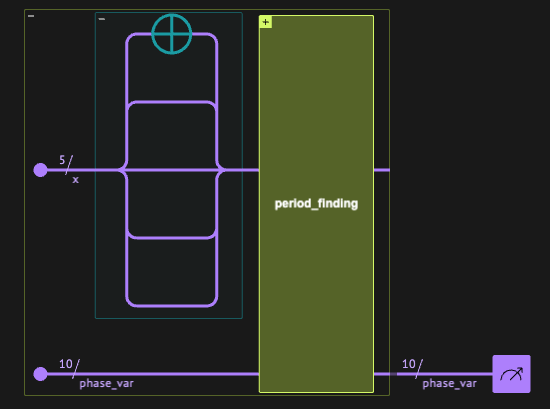
<center>
    The quantum period finding algorithm.
</center>

### Postprocess with continued fractions algorithm

The outcome distribution for the `phase_var` variable out of the QPE is in $[0,1)$, and expected to be peaked around $r$ values: $s/r$ for $s=0,1,\dots, r-1$. We can extract the value of $r$ by using the continued fractions algorithm: any rational (irrational) number can be written as a finite (infinite) converging sequence of fractions:
$$
x
= a_0
+ \cfrac{1}{a_1
  + \cfrac{1}{a_2
    + \cfrac{1}{a_3
      + \ddots}}} .
$$
There is an efficient classical algorithm for extracting $a_i$. For example, using `sympy`:

In [4]:
from sympy import Rational
from sympy.ntheory.continued_fraction import (
    continued_fraction,
    continued_fraction_convergents,
)

phase_value = Rational(17 / 1024)
list_of_continued_fraction = list(
    continued_fraction_convergents(continued_fraction(phase_value))
)
print(
    f"Continued fraction convergents for {phase_value}:  {list_of_continued_fraction}"
)

Continued fraction convergents for 17/1024:  [0, 1/60, 4/241, 17/1024]


Thus, we can extract $r$ in the following way:
* Filter the distribution of the `phase_var` variable around some threshold.
* For each value of `phase_var`, calculate the series of rational numbers $p_i/q_i$ that correspond to the continued fractions sereis.
* Pick only fractions with $q_i<N$, we should see fractions that fit $s/r$ for $s=0,1,\dots, r-1$.

Let us define a function that applies those steps on the execution results of the period finding algorithm. It gets a dataframe object of the results, and returns a dataframe with the additional data: 

In [5]:
import pandas as pd


def continued_fraction_post_process(df, n, threshold):
    out = df.loc[df["probability"] > threshold].copy()

    def proc(x):
        if pd.isna(x):
            return [], None
        # Extract continued fraction convergents
        convs = list(continued_fraction_convergents(continued_fraction(Rational(x))))
        # Eliminate fractions with denominator > n
        trimmed = [c for c in convs if c.as_numer_denom()[1] < n]
        # Store the last continued fraction_convergent
        lastf = trimmed[-1] if trimmed else None
        return trimmed, lastf

    out[["trimmed_list", "last_frac"]] = (
        out["phase_var"].map(proc).apply(pd.Series, index=["trimmed_list", "last_frac"])
    )
    return out

Let us see an example, consider the following result out of the period finding algorithm:

In [6]:
from IPython.display import display

df_example = pd.DataFrame(
    {
        "phase_var": [0.1953125, 0.39160156, 0.0, 0.125, 0.59667969, 0.80078125],
        "probability": [0.92, 0.35, 0.76, 0.03, 0.90, 0.51],
    }
)
display(df_example)

,phase_var,probability
0,0.195312,0.92
1,0.391602,0.35
2,0.000000,0.76
3,0.125000,0.03
4,0.596680,0.90
5,0.800781,0.51


Our postprocess function adds new columns to the result 

In [7]:
df_example_processed = continued_fraction_post_process(df_example, n=18, threshold=0.1)
display(df_example_processed)

,phase_var,probability,trimmed_list,last_frac
0,0.195312,0.92,"[0, 1/5]",1/5
1,0.391602,0.35,"[0, 1/2, 1/3, 2/5]",2/5
2,0.000000,0.76,[0],0
4,0.596680,0.90,"[0, 1, 1/2, 3/5]",3/5
5,0.800781,0.51,"[0, 1, 4/5]",4/5


We can see that in this case one can conclude that $r$ is the period we were trying to find.

## Verifying the order and factoring

Once $r$ is found, we first verify that it is an even number, this is because Shor's algorithm continues by writing
$$
a^r=1\bmod{N}\implies \left(a^{r/2}-1\right)\left(a^{r/2}+1\right) = 0 \bmod{N}.
$$
If $r$ is even, this equation implies four scenarios:
1. $\left(a^{r/2}-1\right) = 0 \bmod{N}$, impossible, since it contradicts the fact that $r$ is the order.
2. $\left(a^{r/2}+1\right) = 0 \bmod{N}$,  in that case we must go back to step 1 and start with a new co-prime $a$.
3. $\left(a^{r/2}-1\right)\left(a^{r/2}+1\right) = N$,  which gives a factoring for $N$.
4. $\left(a^{r/2}-1\right)\left(a^{r/2}+1\right) = kN$ with $k>1$, which means that $N$ divides the of the terms on the left. Thus, it has a non-trivial common divisor with one of them, namely, $\mathrm{gcd}(a^{r/2}+1,N)\neq 1$ and/or $\mathrm{gcd}(a^{r/2}-1,N)\neq 1$ are factors of $N$.

It can be shown that the situations in which $r$ is odd or $\left(a^{r/2}+1\right) = 0 \bmod{N}$ can happen at probability 1/2 at most.
Below we define a function that verifies we are not in the second possibility, and returns the factors on $N$ in case we are at the last two.

In [8]:
def get_factors(a, r, n):
    # r is odd
    if r % 2 == 1:
        print(f"The order r={r} is odd, return to the first step and find a co-prime a")
        return None, None
    # a^(r/2)=-1 mod n is odd
    if a ^ (r // 2) + 1 % n == 0:
        print(
            f"It turns out that a^(r/2)+1 % N ==0, return to the first step and find a co-prime a"
        )
        return None, None
    # (a^(r/2)+1) (a^(r/2)-1)=n
    if (a ^ (r // 2) + 1) * (a ^ (r // 2) - 1) == n:
        return (a ^ (r // 2) + 1), (a ^ (r // 2) - 1)
    # (a^(r/2)+1) (a^(r/2)-1)= kn, with k>1
    gcd_ = np.gcd((a ^ (r // 2) + 1), n)
    if gcd_ > 1:
        return int(gcd_), int(n / gcd_)
    gcd_ = np.gcd((a ^ (r // 2) - 1), n)
    return int(gcd_), int(n / gcd_)

## Example: Factoring 21

First, find a co-prime of $N$. We fix this value to $a=11$ in order to get a full end-to-end result that runs the quantum part.

In [9]:
np.random.seed(989)

modulo_num = 21  # The number we wish to factor
a_num, gcd_a_num = random_coprime(modulo_num)
print(
    f"The numbers {a_num} and {modulo_num} have the greatest common divisor {gcd_a_num}"
)

assert a_num == 11

The numbers 11 and 21 have the greatest common divisor 1


Next, we run the quantum period finding algorithm to extract the period $r$. Concerning the size of the quantum variables:
-  The quantum variable on which we apply the period finding, $|x\rangle$, should have the number of bits according to $N$ (we note that our current `inplace_modular_multiply` uses an extra of `x.size`+1 auxiliary qubits).
- For the phase variable that approximates the period $r$, we take twice the size of $|x\rangle$: this gives a sufficient accuracy for extracting the period with the continued fraction algorithm. 

In [10]:
x_len = modulo_num.bit_length()
phase_len = 2 * x_len


@qfunc
def main(phase_var: Output[QNum[phase_len, UNSIGNED, phase_len]]):
    x = QNum()
    allocate(x_len, x)
    allocate(phase_var)
    x ^= 1
    period_finding(modulo_num, a_num, x, phase_var)


write_qmod(main, "shor")
qprog = synthesize(
    main,
    preferences=Preferences(qasm3=True),
)

In [11]:
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/33PfUBDRL5owrrrS0oAA7hrUcks


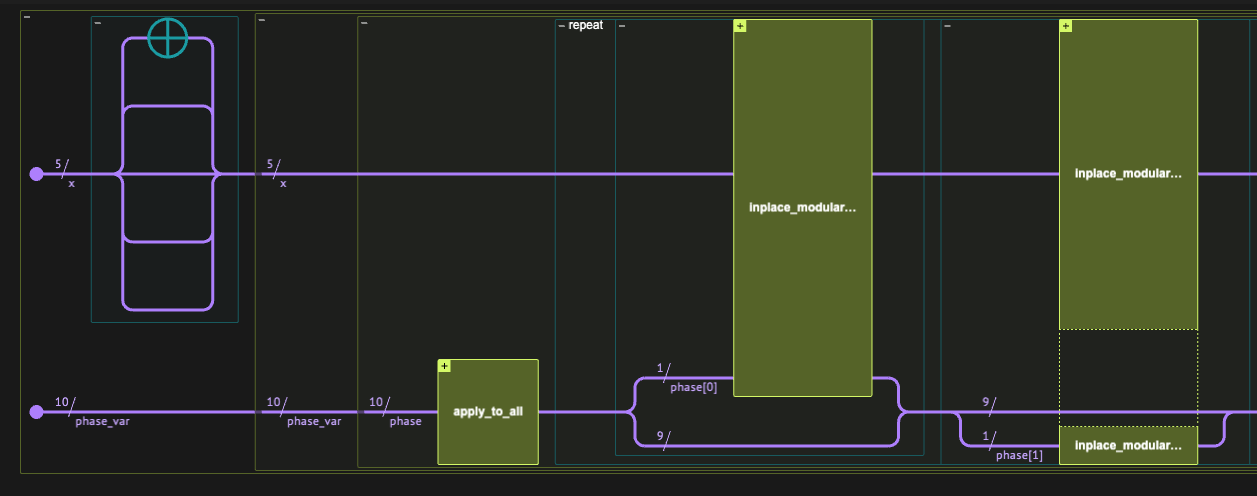
<center>
    Shor's algorithm for factoring $N=21$.
</center>

We execute and postprocess the results with the continued fraction approximation

In [12]:
result = execute(qprog).get_sample_result()
df = result.dataframe
processed_df = continued_fraction_post_process(df=df, n=modulo_num, threshold=0.05)

In [13]:
display(processed_df)

,phase_var,count,probability,bitstring,trimmed_list,last_frac
0,0.500000,345,0.168457,1000000000,"[0, 1/2]",1/2
1,0.000000,344,0.167969,0000000000,[0],0
2,0.333008,234,0.114258,0101010101,"[0, 1/3]",1/3
3,0.833008,233,0.113770,1101010101,"[0, 1, 4/5, 5/6]",5/6
4,0.166992,229,0.111816,0010101011,"[0, 1/5, 1/6]",1/6
5,0.666992,213,0.104004,1010101011,"[0, 1, 2/3]",2/3


We can plot the full distribution, together with the continued fraction approximation

In [14]:
import matplotlib.pyplot as plt

df = df.sort_values("phase_var")
processed_df = processed_df.sort_values("phase_var")

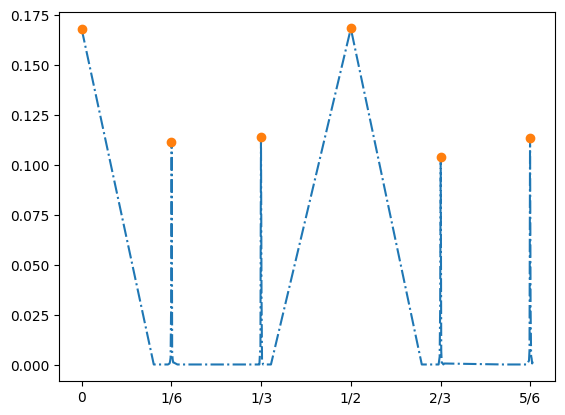

In [15]:
plt.plot(df.phase_var, df.probability, "-.")
plt.plot(processed_df.last_frac, processed_df.probability, "o")
fracs = sorted(set(processed_df["last_frac"].dropna().tolist()), key=float)

positions = [float(f) for f in fracs]
labels = ["0" if f == 0 else f"{f.numerator}/{f.denominator}" for f in fracs]

plt.xticks(positions, labels);

We can clearly see that we have peaks at $\frac{0}{6}, \frac{1}{6}, \frac{2}{6}, \frac{3}{6} , \frac{4}{6}, \frac{5}{6}$, that is, the order is $r=6$.

In [16]:
for p in positions:
    assert (p * 6).is_integer()
r = 6

All is left is to run the final step that determines the factor of $N$ out of $a$ and $r$:

In [17]:
factor1, factor2 = get_factors(a_num, r, modulo_num)
assert factor1 * factor2 == modulo_num
print(f"The number {modulo_num} is factored by {factor1} and {factor2}")

The number 21 is factored by 3 and 7


## Technical Notes

### The eigenphases and eigenstates of $f(x) = ax\bmod{N}$

Below we prove the claim that the modular multiplication by $a$, which is a co-prime of $N$, has the following eigenstates:
$$
|\psi_s\rangle =  \frac{1}{\sqrt{r}}\sum^{r-1}_{k=0}e^{-2\pi i sk/r}|a^{k}\bmod{N}\rangle, \qquad s=0,1,\dots, r-1,
$$
and the corresponding eigenvalues:
$$
\lambda_s = e^{2\pi i s/r},
$$
where $r$ is the order of the function.

It is easy to verify that
$$
a|\psi_s\rangle = \frac{1}{\sqrt{r}}\sum^{r-1}_{k=0}e^{-2\pi i sk/r}|a^{k+1}\bmod{N}\rangle = 
\frac{1}{\sqrt{r}}\sum^{r}_{k=1}e^{2\pi i s/r}e^{-2\pi i sk/r}|a^{k}\bmod{N}\rangle = e^{2\pi i s/r}\frac{1}{\sqrt{r}}\sum^{r-1}_{k=0}e^{-2\pi i sk/r}|a^{k}\bmod{N}\rangle = e^{2\pi i s/r}a|\psi_s\rangle,
$$
where in the second equality we just changed the sum index $k \rightarrow k-1$, and the third one comes from the fact that the terms under the sum have a period of $r$, and the $r$-th term is equal to the $0$-th one.

### The initial state $|1\rangle$ for the QPE

Bwlow we show that the state $|1\rangle$ is an equal superposition of $|\psi_s\rangle$. We use the fact that 
$$
\sum^{r-1}_{k'=0} e^{-2\pi i k'k/r} = r\cdot \delta_{k0},
$$
namely, the sum vanishes unless $k=0$. Calculating explicitly, we get
$$
\frac{1}{\sqrt{r}}\sum^{r-1}_{k'=0}|\psi_{k'}\rangle = \frac{1}{r}\sum^{r-1}_{k'=0} \sum^{r-1}_{k=0}e^{-2\pi i k'k/r}|a^{k}\bmod{N}\rangle
=\frac{1}{r}\sum^{r-1}_{k=0} \left(\sum^{r-1}_{k'=0} e^{-2\pi i k'k/r}\right)|a^{k}\bmod{N}\rangle
=\frac{1}{r}\sum^{r-1}_{k=0} r\delta_{k0}|a^{k}\bmod{N}\rangle = |1\rangle.
$$

<h2 id="references">References</h2>
<ol>
  <li id="ref-integerfactor">
    Integer Factorization (Wikipedia) 
    &nbsp;-&nbsp;
    <a href="https://en.wikipedia.org/wiki/Integer_factorization" target="_blank" rel="noopener noreferrer">Wikipedia &#8599;</a>
  </li>
  <li id="ref-shor94">
    P. W. Shor, "Algorithms for quantum computation: Discrete logarithms and factoring," Proceedings 35th Annual Symposium on Foundations of Computer Science (FOCS), IEEE, 1994. 
    &nbsp;-&nbsp;
    <a href="https://ieeexplore.ieee.org/abstract/document/365700" target="_blank" rel="noopener noreferrer">IEEE &#8599;</a>
  </li>
  <li id="ref-shorsteps">
    Shor's Algorithm Procedure (Wikipedia) 
    &nbsp;-&nbsp;
    <a href="https://en.wikipedia.org/wiki/Shor%27s_algorithm#Procedure" target="_blank" rel="noopener noreferrer">Wikipedia &#8599;</a>
  </li>
  <li id="ref-nielsenchuang">
    M. A. Nielsen & I. L. Chuang, "Quantum Computation and Quantum Information", Cambridge Univ. Press, 2001. ISBN 978-9812388582.
  </li>
<li id="ref-kiteav">
   Kitaev, A. Yu. "Quantum measurements and the Abelian Stabilizer Problem". arXiv:quant-ph/9511026 (1995).
    &nbsp;-&nbsp;
      <a href="https://arxiv.org/abs/quant-ph/9511026" target="_blank" rel="noopener noreferrer">arxiv &#8599;</a>
</ol>
